https://arxiv.org/pdf/1312.6114.pdf (vae paper)<br/>
https://docs.google.com/presentation/d/1FkkhH86URDzAzjNPdCvupV6kqoBNNarVQQgB6ppZlx4/edit#slide=id.g26890724310_0_7 (latent variable models lecture notes) <br/>

In [ ]:
!pip install datasets
!pip install wandb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import wandb
import numpy as np

In [ ]:
!wandb login

wandb: Currently logged in as: carlfeynman. Use `wandb login --relogin` to force relogin


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device', device)

device cpu


In [ ]:
dataset = load_dataset('mnist')

In [ ]:
def transform_data(b):
    b['image'] = [TF.to_tensor(o) for o in  b['image']]
    return  b

def collate_dict(b):
    c = default_collate(b)
    return (c['image'].to(device), c['label'])

In [ ]:
batch_size = 1024

In [ ]:
train_ds = dataset['train'].with_transform(transform_data)
valid_ds = dataset['test'].with_transform(transform_data)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_dict)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, collate_fn=collate_dict)

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

tensor(3)


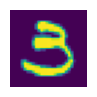

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(xb[10][0].detach().cpu());
plt.axis('off');
print(yb[10])


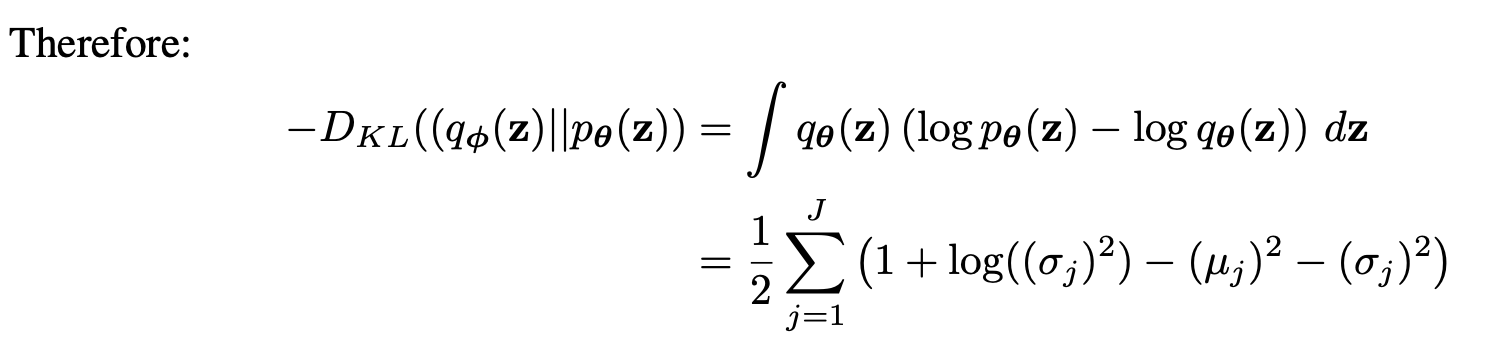

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim=30, beta=1):
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = beta

        self.stride = 2
        self.kernel_size = 3
        self.padding = self.kernel_size//2

        self.enc = nn.Sequential(*[
            nn.Conv2d(1, 8, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64, self.latent_dim)
        ])

        self.mu_layer = nn.Linear(self.latent_dim, self.latent_dim)
        self.log_var_layer = nn.Linear(self.latent_dim, self.latent_dim)

        self.dec = nn.Sequential(*[
            nn.Linear(self.latent_dim, 64*2*2),
            nn.ReLU(),
            nn.Unflatten(1, (64,2,2)),
            nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size,
                               padding=self.padding, stride=self.stride, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=self.kernel_size,
                               padding=self.padding, stride=self.stride, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=self.kernel_size,
                               padding=self.padding, stride=self.stride, output_padding=1),
            nn.BatchNorm2d(8),

            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=self.kernel_size,
                               padding=self.padding, stride=2, output_padding=0),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(961, 28*28),
            nn.Unflatten(1, (1,28,28)),
            nn.Sigmoid()
        ])

    def reparameterize(self, mu, log_var):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return mu + eps*std

    def loss(self, xb, out, mu, log_var):
      self.rec_loss = F.mse_loss(xb, out, reduction='sum')
      std = torch.exp(0.5*log_var)
      self.kl_loss = -0.5*torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
      return self.rec_loss + self.beta*self.kl_loss

    def forward(self, x):
        latent = self.enc(x)

        mu = self.mu_layer(latent)
        log_var = self.log_var_layer(latent)

        z = self.reparameterize(mu, log_var)
        out = self.dec(z)

        return out, mu, log_var

In [ ]:
model = VariationalAutoEncoder().to(device)
model

VariationalAutoEncoder(
  (enc): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): L

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = f"{total_params / 1_000_000:.2f}M"
print(f"total number of parameters: {total_params}")

total number of parameters: 0.85M


In [ ]:
out,mu,log_var = model(xb)
out.shape,mu.shape,log_var.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024, 30]), torch.Size([1024, 30]))

In [ ]:
epochs = 20
lr = 6e-2
model = VariationalAutoEncoder().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)

wandb.init(
    project="variational_autoencoder",
    config={
      "learning_rate": lr,
      "architecture": "CNN",
      "dataset": "MNIST",
      "epochs": epochs,
      "total_params": total_params,
      "model":model
    }
)

for epoch in range(epochs):
    for xb,yb in train_dl:
        out,mu,log_var = model(xb)
        loss = model.loss(xb, out, mu, log_var)
        loss.backward()
        opt.step()
        opt.zero_grad()

        with torch.no_grad():
          sample_mu = torch.zeros((5, model.latent_dim))
          sample_log_var = torch.ones((5, model.latent_dim))
          samples = model.reparameterize(sample_mu, sample_log_var)
          samples_out = model.dec(samples)

          wandb.log({"loss": round(loss.item(), 4),
                     "reconstruct_loss": round(model.rec_loss.item(), 4),
                     "kl_loss": round(model.kl_loss.item(), 4)})
          orginial_img = [wandb.Image(o, caption="original") for o in xb.detach().cpu()[:5]]
          reconstructed_img = [wandb.Image(o, caption="reconstructed_img") for o in out.detach().cpu()[:5]]
          generated_sample = [wandb.Image(o, caption="generated_sample") for o in samples_out.detach().cpu()[:5]]
          wandb.log({"original": orginial_img, "reconstructed_img": reconstructed_img, 'generated_sample':generated_sample})

    print(f"loss {loss.item():.4f}")

wandb.finish()

loss 32041.8262
loss 32142.9727
loss 31812.3418
loss 32515.2559
loss 32056.7734
loss 32505.4043
loss 32160.3711
loss 32087.6289


In [ ]:
# wandb.finish()

kl_loss,▁▇▄▄▅██▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
loss,█▆▄▅▅▇▇▅▄▄▄▄▄▄▄▄▄▃▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▁▃▃▃▃▃
reconstruct_loss,█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▃▃▃▃▃
kl_loss,4430.3066
loss,97190.8281
reconstruct_loss,92760.5234


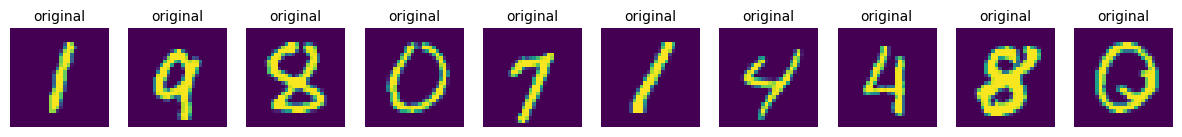

In [ ]:
plot_sz = 10
_,axs = plt.subplots(1, plot_sz, figsize=(15, 15))
for im,ax in zip(xb,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('original', fontsize=10)

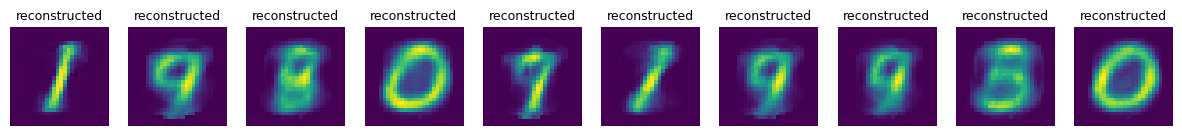

In [ ]:
_,axs = plt.subplots(1, plot_sz, figsize=(15, 15))
for im,ax in zip(out,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('reconstructed', fontsize=9)

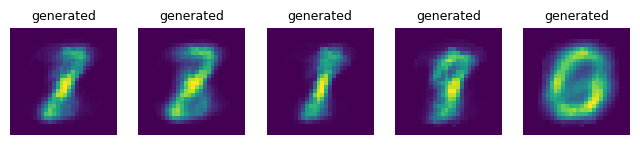

In [ ]:
_,axs = plt.subplots(1, 5, figsize=(8, 8))
for im,ax in zip(samples_out,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('generated', fontsize=9)